<a href="https://colab.research.google.com/github/ruus77/data_analysis/blob/main/Real_Estate_Price_Prediction_using_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be using the Real Estate Valuation Data Set [Real estate valuation](https://archive-beta.ics.uci.edu/dataset/477/real+estate+valuation+data+set). The dataset contains seven variables: the transaction date, house age, distance (in meters) to the nearest mass transit station (MRT), the number of convenience stores in the local area, the property's geographical coordinates (latitude and longitude), and the house price per unit area (originally 10,000 New Taiwan Dollars per Ping).

In [180]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error

import datetime
import warnings

warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [181]:
def set_seeds(num:int=42):
  np.random.seed(num)

## Data Preparation and Feature Engineering


In [182]:
df = pd.read_csv("real_estate.csv")
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [183]:
df.dtypes

,0
No,int64
X1 transaction date,float64
X2 house age,float64
X3 distance to the nearest MRT station,float64
X4 number of convenience stores,int64
X5 latitude,float64
X6 longitude,float64
Y house price of unit area,float64


In [184]:
df.shape

(414, 8)

In [185]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
list(df.columns)


['no',
 'x1_transaction_date',
 'x2_house_age',
 'x3_distance_to_the_nearest_mrt_station',
 'x4_number_of_convenience_stores',
 'x5_latitude',
 'x6_longitude',
 'y_house_price_of_unit_area']

##Detecting and Removing Outliers

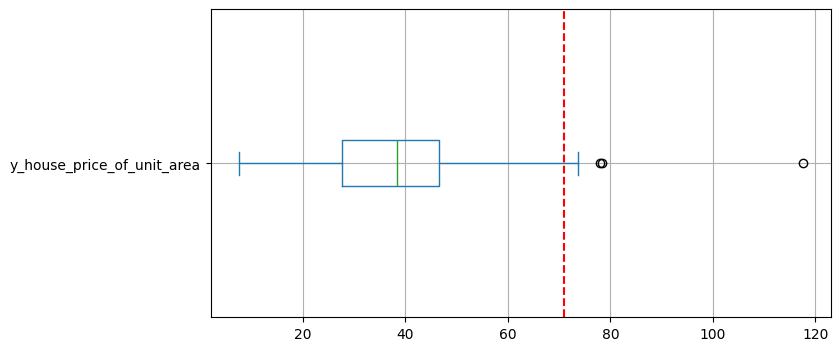

In [186]:
df.y_house_price_of_unit_area.plot.box(grid=True, figsize=(8, 4), vert=False);
plt.axvline(x=df.y_house_price_of_unit_area.quantile(.99), color="red", linestyle="--");

In [187]:
df.y_house_price_of_unit_area.max()

117.5

In [188]:
df.loc[df.y_house_price_of_unit_area == df.y_house_price_of_unit_area.max(), :]

,no,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
270,271,2013.333,10.8,252.5822,1,24.9746,121.53046,117.5


In [189]:
df.drop(270, inplace=True)

In [190]:
df.y_house_price_of_unit_area.max()

78.3

In [191]:
df.x1_transaction_date.head()

,x1_transaction_date
0,2012.917
1,2012.917
2,2013.583
3,2013.500
4,2012.833


In [192]:
rest = df.x1_transaction_date.apply(lambda x: x % 1)
rest.head()

,x1_transaction_date
0,0.917
1,0.917
2,0.583
3,0.500
4,0.833


In [193]:
approx_month = 12*rest
approx_month = approx_month.apply(lambda x: round(x)) + 1
approx_month.head()

,x1_transaction_date
0,12
1,12
2,8
3,7
4,11


In [194]:
df.x1_transaction_date = df.x1_transaction_date.apply(lambda x: math.floor(x))
df.x1_transaction_date.head()

,x1_transaction_date
0,2012
1,2012
2,2013
3,2013
4,2012


In [195]:
df.x1_transaction_date = df.x1_transaction_date.astype(str).str.cat(approx_month.astype(str), sep="-")
df.x1_transaction_date = pd.to_datetime(df.x1_transaction_date)
df.head()

,no,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012-12-01,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012-12-01,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013-08-01,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013-07-01,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012-11-01,5.0,390.56840,5,24.97937,121.54245,43.1


In [196]:
today = datetime.datetime.today()
today = today.strftime("%Y-%m-%d")

In [197]:
df["x1_from_today"] = today
df["x1_from_today"] = pd.to_datetime(df["x1_from_today"])

In [198]:
df.x1_from_today = df.x1_from_today - df.x1_transaction_date
df.x1_from_today.sample(5)

,x1_from_today
174,4512 days
358,4604 days
238,4632 days
53,4632 days
123,4512 days


In [199]:
df.x1_from_today = df.x1_from_today.astype(str)
df.x1_from_today = df.x1_from_today.str.split(" ").str[0]
df.x1_from_today = df.x1_from_today.astype(int)
df.head()

,no,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area,x1_from_today
0,1,2012-12-01,32.0,84.87882,10,24.98298,121.54024,37.9,4694
1,2,2012-12-01,19.5,306.59470,9,24.98034,121.53951,42.2,4694
2,3,2013-08-01,13.3,561.98450,5,24.98746,121.54391,47.3,4451
3,4,2013-07-01,13.3,561.98450,5,24.98746,121.54391,54.8,4482
4,5,2012-11-01,5.0,390.56840,5,24.97937,121.54245,43.1,4724


In [200]:
df = df.drop(columns=["x1_transaction_date"], axis=1)
df.head()

,no,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area,x1_from_today
0,1,32.0,84.87882,10,24.98298,121.54024,37.9,4694
1,2,19.5,306.59470,9,24.98034,121.53951,42.2,4694
2,3,13.3,561.98450,5,24.98746,121.54391,47.3,4451
3,4,13.3,561.98450,5,24.98746,121.54391,54.8,4482
4,5,5.0,390.56840,5,24.97937,121.54245,43.1,4724


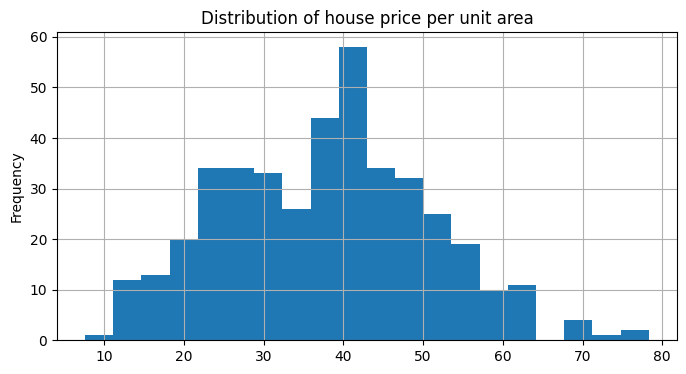

In [201]:
df.y_house_price_of_unit_area.plot.hist(bins=20, grid=True, figsize=(8, 4), title="Distribution of house price per unit area");

In [202]:
df["x4_number_of_convenience_stores"].value_counts().sort_index(ascending=False)

,count
x4_number_of_convenience_stores,
10,10
9,25
8,30
7,31
6,37
5,67
4,31
3,46
2,24


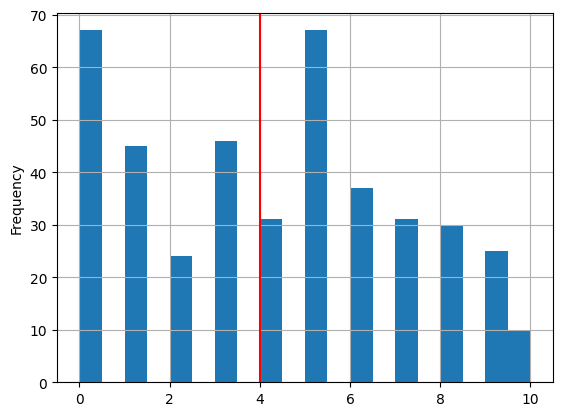

In [203]:
df["x4_number_of_convenience_stores"].plot.hist(bins=20, grid=True)
plt.axvline(df["x4_number_of_convenience_stores"].median(), color="r");

In [204]:
df.x4_number_of_convenience_stores = np.where(df.x4_number_of_convenience_stores > df.x4_number_of_convenience_stores.quantile(0.5), 1, 0)
df.x4_number_of_convenience_stores.value_counts()

,count
x4_number_of_convenience_stores,
0,213
1,200


<Axes: ylabel='Frequency'>

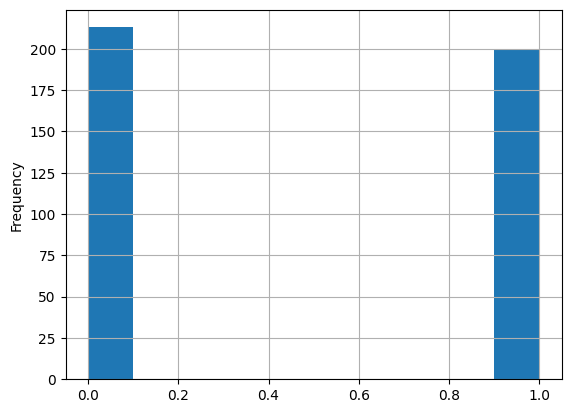

In [205]:
df["x4_number_of_convenience_stores"].plot.hist(grid=True)

## Key Exploratory Data Analysis

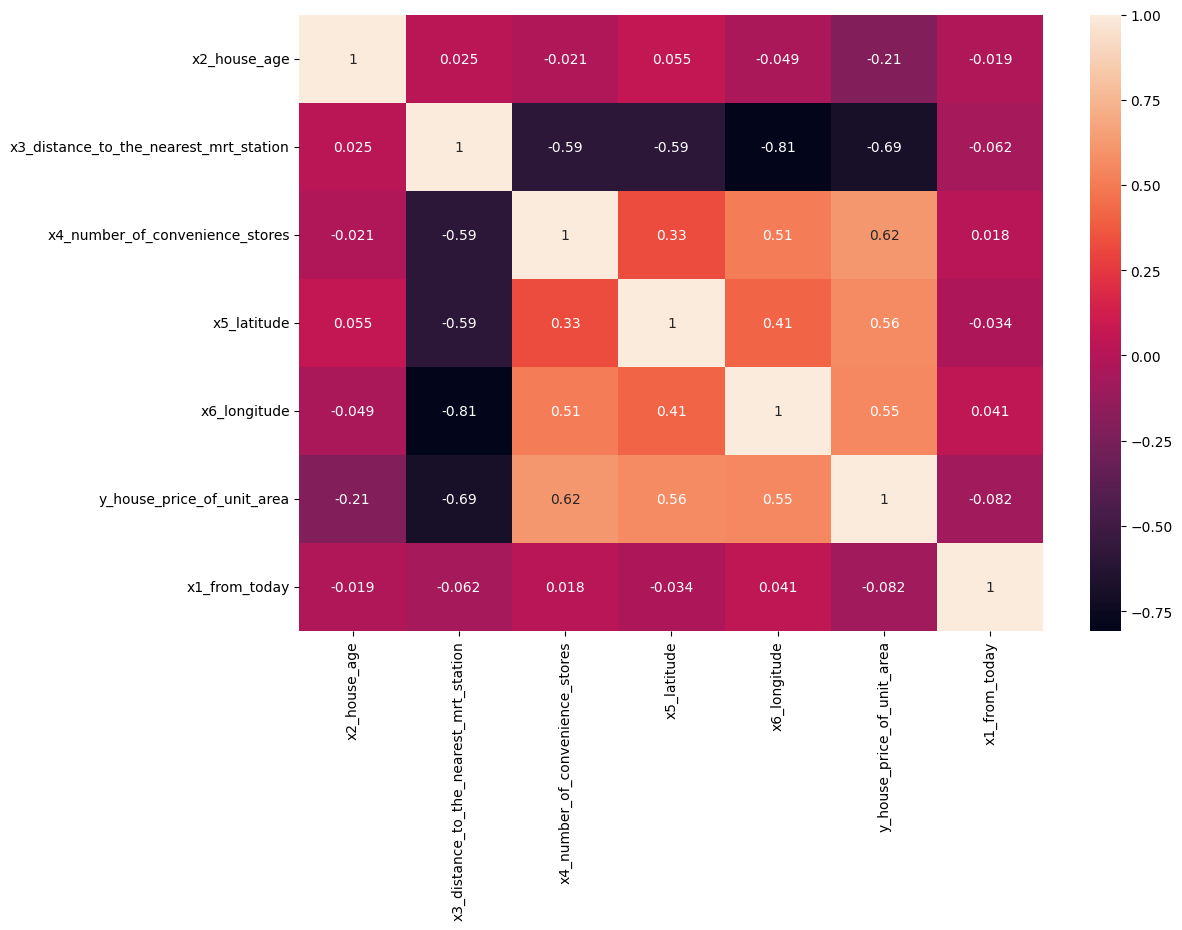

In [206]:
corr = df.drop(columns="no").corr()
plt.figure(figsize=[12,8])
sns.heatmap(corr, annot=True)
plt.show()

In [207]:
corr.y_house_price_of_unit_area.sort_values(ascending=False)

,y_house_price_of_unit_area
y_house_price_of_unit_area,1.000000
x4_number_of_convenience_stores,0.615139
x5_latitude,0.563954
x6_longitude,0.549250
x1_from_today,-0.081808
x2_house_age,-0.210985
x3_distance_to_the_nearest_mrt_station,-0.694009


## Model Training and Performance
Linear Regression formula:

$$y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i + \epsilon$$

In [208]:
x_list = list(df.columns)
x_list.remove("y_house_price_of_unit_area")
x_list.remove("no")
x_list

['x2_house_age',
 'x3_distance_to_the_nearest_mrt_station',
 'x4_number_of_convenience_stores',
 'x5_latitude',
 'x6_longitude',
 'x1_from_today']

In [209]:
X = df.loc[:, x_list]
X.head()

,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,x1_from_today
0,32.0,84.87882,1,24.98298,121.54024,4694
1,19.5,306.59470,1,24.98034,121.53951,4694
2,13.3,561.98450,1,24.98746,121.54391,4451
3,13.3,561.98450,1,24.98746,121.54391,4482
4,5.0,390.56840,1,24.97937,121.54245,4724


In [210]:
X = df.loc[:, x_list]
X.head()

,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,x1_from_today
0,32.0,84.87882,1,24.98298,121.54024,4694
1,19.5,306.59470,1,24.98034,121.53951,4694
2,13.3,561.98450,1,24.98746,121.54391,4451
3,13.3,561.98450,1,24.98746,121.54391,4482
4,5.0,390.56840,1,24.97937,121.54245,4724


In [211]:
X = df.loc[:, x_list]
X.head()

,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,x1_from_today
0,32.0,84.87882,1,24.98298,121.54024,4694
1,19.5,306.59470,1,24.98034,121.53951,4694
2,13.3,561.98450,1,24.98746,121.54391,4451
3,13.3,561.98450,1,24.98746,121.54391,4482
4,5.0,390.56840,1,24.97937,121.54245,4724


In [212]:
y = df.y_house_price_of_unit_area
y.head()

,y_house_price_of_unit_area
0,37.9
1,42.2
2,47.3
3,54.8
4,43.1


In [213]:
X_norm  = normalize(X, norm="max", axis=0)
y_norm = normalize(y.to_numpy().reshape((-1, 1)), norm="max", axis=0)

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, shuffle=True, test_size=0.4)

In [215]:
model = LinearRegression()
model.fit(X_train, y_train);

In [216]:
model.score(X_train, y_train)

0.6214677777329756

In [217]:
model.score(X_test, y_test)

0.655173253521331

In [218]:
y_pred = model.predict(X_test)

In [219]:
y_pred.shape, y_test.shape

((166, 1), (166, 1))

In [220]:
residuals = y_test - y_pred
y_plot = [y_pred ,residuals.ravel()]

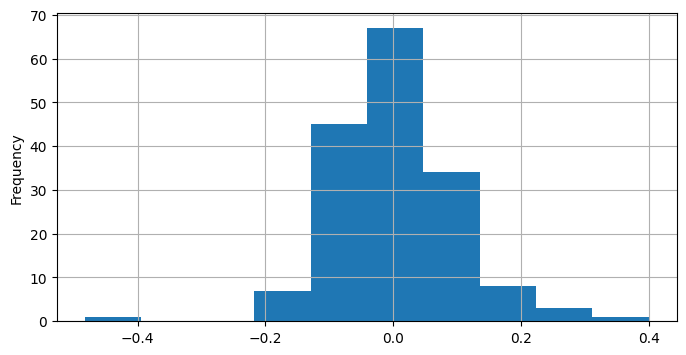

In [221]:
pd.Series(residuals.ravel()).plot.hist(figsize=(8, 4), bins= 10, grid=True);

In [222]:
y_plot = pd.DataFrame(y_pred ,residuals.ravel())

In [223]:
print(model.intercept_)

[7.51620564]


In [224]:
mean_absolute_error(y_true=y_test,
               y_pred=y_pred)

0.07418049374952329